# Práctico 3: Validación cruzada y Regularización

## Objetivos del trabajo

* Objetivo general:
    - introducir las técnicas de validación cruzada y regularización

* Objetivos específicos:
    - continuar el estudio del dataset de la ECH, en este caso con una variable de respuesta continua
    - aplicar herramientas de análisis estadístico descriptivo adecuadas al caso
    - aplicar las técnicas de validación cruzada y regularización

    
## Presentación del caso de estudio

* Predicción del ingreso de las personas:
    - queremos desarrollar un modelo de predicción de los ingresos de las porsonas por trabajo en relación de dependencia, a partir de los datos de la ECH
    
1. Objetivo:

    * **Tarea (T)**: Predicción del ingreso de las personas por su trabajo en relación de dependencia, a partir de los datos de la ECH 
    * **Entrenamiento (E)**: Utilizamos los datos de la Encuesta Continua de Hogares del INE (ECH) de 2017        
    * **Performance (P)**: buscamos minimizar el error de predicción definido como MSE (error cuadrático medio)   


2. Links de referencia:

    * [Encuesta Continua de Hogares 2017](https://anterior.ine.gub.uy/web/guest/encuesta-continua-de-hogares1) 
    * Datos a utilizar: [Bases ECH 2017 en formato sav](https://anterior.ine.gub.uy/c/document_library/get_file?uuid=e38ea53c-7253-4007-9f67-2f5f161eea91&groupId=10181)
    * [Diccionario de variables ECH 2017](https://anterior.ine.gub.uy/c/document_library/get_file?uuid=b60f247b-03cb-4bb1-b84b-5d7328479fe2&groupId=10181)
        
    
3. Entendimiento del caso:

    * Lectura de la documentación de los datos de la ECH
    * Análisis del diccionario de datos de la ECH
    * ¿Cuál es la variable objetivo *Y*?
    * Planteo inicial de hipótesis: Definición del enfoque de uso de variables (no existe receta)
        - de menos a más: variable por variable, probando una hipótesis a la vez, utilizando combinaciones
        - usar todas las variables de una vez

## Setup

* Importación de las librerías

In [1]:
# import packages
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline # Pipeline
from sklearn.model_selection import train_test_split # Creating Train / Test Split
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import cross_val_score # Usage of cross_val_score for computing cross-validation scores

* Seteo de directorio de trabajo

In [2]:
os.chdir(r'/home/jovyan/work/pr_3')

## Importación de los datos

In [3]:
# import data
dfP2017 = pd.read_spss(r'data/Base ECH 2017 formato SAV/P_2017_Terceros.sav')

## Preparación de los datos

In [4]:
df_ysos = pd.DataFrame()

# variable de respuesta
df_ysos['ysos_dep'] = dfP2017['g126_1'] + dfP2017['g126_2'] + dfP2017['g126_3'] + dfP2017['g126_4'] \
                      + dfP2017['g134_1'] + dfP2017['g134_2'] + dfP2017['g134_3'] + dfP2017['g134_4']

# atributos

## caracteristicas personales
df_ysos['edad'] = dfP2017['e27']
df_ysos['sexo'] = dfP2017['e26']

## educación
df_ysos['anios_educ'] = dfP2017['e51_2'] + dfP2017['e51_3'] + dfP2017['e51_4'] + dfP2017['e51_5'] + dfP2017['e51_6'] \
                        + dfP2017['e51_7'] + dfP2017['e51_8'] + dfP2017['e51_9'] + dfP2017['e51_10'] + dfP2017['e51_11']

## relación de empleo
df_ysos['antiguedad'] = dfP2017['f88_2']
df_ysos['categoria_ocup'] = dfP2017['f73']


In [5]:
# podemos filtrar acá: como se respeta el índice, incluso podríamos considerar luego otras variables del dataset original
df_ysos = df_ysos[df_ysos['ysos_dep'] > 0]

In [6]:
df_ysos = df_ysos.loc[(df_ysos['categoria_ocup'] == "Asalariado/a privado/a") | (df_ysos['categoria_ocup'] == "Asalariado/a público/a")]

In [7]:
df_ysos['l_ysos_dep'] = np.log(df_ysos['ysos_dep'])
df_l_ysos = df_ysos.drop(columns=['ysos_dep'])
df_l_ysos.head()

,edad,sexo,anios_educ,antiguedad,categoria_ocup,l_ysos_dep
0,70.0,Hombre,6.0,7.0,Asalariado/a privado/a,9.798127
2,52.0,Hombre,6.0,32.0,Asalariado/a público/a,10.778956
5,42.0,Mujer,16.0,0.0,Asalariado/a privado/a,10.404263
7,29.0,Mujer,8.0,1.0,Asalariado/a privado/a,7.783224
8,37.0,Hombre,6.0,4.0,Asalariado/a privado/a,10.043249


In [8]:
categorical_columns = ['sexo', 'categoria_ocup']
numerical_columns = ['edad', 'anios_educ', 'antiguedad']

# función transformadora
column_transform = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns), # cuando son dos categorías, elimina una
    #(StandardScaler(), numerical_columns), # comentado mientras no se decida estandarizar
    remainder='passthrough', # deja el resto de las columnas sin transformar
    verbose_feature_names_out=False)

In [9]:
df_l_ysos_transf = pd.DataFrame(
    column_transform.fit_transform(df_l_ysos), 
    columns=column_transform.get_feature_names_out()
)

df_l_ysos_transf.head()

,sexo_Mujer,categoria_ocup_Asalariado/a público/a,edad,anios_educ,antiguedad,l_ysos_dep
0,0.0,0.0,70.0,6.0,7.0,9.798127
1,0.0,1.0,52.0,6.0,32.0,10.778956
2,1.0,0.0,42.0,16.0,0.0,10.404263
3,1.0,0.0,29.0,8.0,1.0,7.783224
4,0.0,0.0,37.0,6.0,4.0,10.043249


## División del dataset en Train y Test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_l_ysos_transf[['edad', 'sexo_Mujer', 'anios_educ', 'antiguedad', 'categoria_ocup_Asalariado/a público/a']], \
                                                    df_l_ysos_transf['l_ysos_dep'], 
                                                    test_size=0.20, 
                                                    random_state=1234)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29908, 5), (7477, 5), (29908,), (7477,))

## Generación del Pipeline

**¿Qué es el pipeline en machine learning?** Los pipelines de datos se caracterizan por definir el conjunto de pasos o fases y las tecnologías involucradas en un proceso de movimiento o procesamiento de datos.

In [12]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())

In [13]:
# creating a pipe using the make_pipeline method
pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())
  
#fitting data into the model
pipeline.fit(X_train, y_train)
  
# predicting values
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

In [14]:
print('Model Error Train: %.4f' % mean_squared_error(y_train, y_train_pred))
print('Model Error Test: %.4f' % mean_squared_error(y_test, y_test_pred))

Model Error Train: 0.3703
Model Error Test: 0.3737


## Validación cruzada

- Información de la función **cross_val_score**: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

- Información de scoring: https://scikit-learn.org/stable/modules/model_evaluation.html

In [15]:
k_folds = 10

In [16]:
scores_cv = cross_val_score(pipeline, X = X_train, y = y_train, cv = k_folds, scoring='neg_mean_squared_error')
print('CV Error for a %s folds: \n%s' %(k_folds, -1*scores_cv))

CV Error for a 10 folds: 
[0.36184985 0.34843655 0.37479687 0.36835287 0.37265196 0.3570935
 0.39058732 0.36250988 0.36535322 0.40296933]


In [17]:
print('Model Error CV: %.3f +/- %.3f' % (-1*np.mean(scores_cv),np.std(scores_cv)))

Model Error CV: 0.370 +/- 0.015


In [18]:
error_train = mean_squared_error(y_train, y_train_pred)
error_test = mean_squared_error(y_test, y_test_pred)
error_cv = -1*np.mean(scores_cv)

In [19]:
print('Model Error Train: %.4f' % error_train)
print('Model Error CV   : %.4f' % error_cv)
print('Model Error Test : %.4f' % error_test)

Model Error Train: 0.3703
Model Error CV   : 0.3705
Model Error Test : 0.3737


**Tarea 2.6: Incorporar más variables. Analizar los resultados para CV y conclusiones**
   - Respuesta 2.6: 

## Realizamos implementación de CV con varias fórmulas (sesgos inductivos)

* aprovechamos salida de sm.OLS, por lo que agregamos una constante al dataset de train
* luego debemos descartar (o no indluir) la constante en el dataset de train al utilizar la función cross_validate
* por qué 'neg_mean_squared_error': https://stackoverflow.com/questions/48244219/is-sklearn-metrics-mean-squared-error-the-larger-the-better-negated

In [20]:
import statsmodels.api as sm
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

In [21]:
model = LinearRegression()

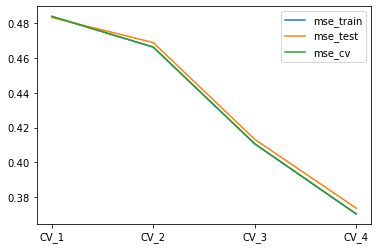

In [22]:
# preparación de datasets X_train, X_test con distintas variables independientes
independent_1 = ['anios_educ']
independent_2 = ['antiguedad']
independent_3 = ['edad', 'sexo_Mujer', 'anios_educ']
independent_4 = ['edad', 'sexo_Mujer', 'anios_educ', 'antiguedad', 'categoria_ocup_Asalariado/a público/a']

CV_1_X_train = sm.add_constant(X_train[independent_1])
CV_2_X_train = sm.add_constant(X_train[independent_2])
CV_3_X_train = sm.add_constant(X_train[independent_3])
CV_4_X_train = sm.add_constant(X_train[independent_4])

CV_1_X_test = sm.add_constant(X_test[independent_1])
CV_2_X_test = sm.add_constant(X_test[independent_2])
CV_3_X_test = sm.add_constant(X_test[independent_3])
CV_4_X_test = sm.add_constant(X_test[independent_4])

# ajuste en datos de entrenamiento
modCV_1 = sm.OLS(y_train, CV_1_X_train).fit()
modCV_2 = sm.OLS(y_train, CV_2_X_train).fit()
modCV_3 = sm.OLS(y_train, CV_3_X_train).fit()
modCV_4 = sm.OLS(y_train, CV_4_X_train).fit()

# predicción en datos de entrenamiento
CV_1_y_train_pred = modCV_1.predict(CV_1_X_train)
CV_2_y_train_pred = modCV_2.predict(CV_2_X_train)
CV_3_y_train_pred = modCV_3.predict(CV_3_X_train)
CV_4_y_train_pred = modCV_4.predict(CV_4_X_train)

# predicción en datos de test
CV_1_y_test_pred = modCV_1.predict(CV_1_X_test)
CV_2_y_test_pred = modCV_2.predict(CV_2_X_test)
CV_3_y_test_pred = modCV_3.predict(CV_3_X_test)
CV_4_y_test_pred = modCV_4.predict(CV_4_X_test)

# MSE en train
CV_1_mse_train = mean_squared_error(y_train, CV_1_y_train_pred)
CV_2_mse_train = mean_squared_error(y_train, CV_2_y_train_pred)
CV_3_mse_train = mean_squared_error(y_train, CV_3_y_train_pred)
CV_4_mse_train = mean_squared_error(y_train, CV_4_y_train_pred)

# MSE en test
CV_1_mse_test = mean_squared_error(y_test, CV_1_y_test_pred)
CV_2_mse_test = mean_squared_error(y_test, CV_2_y_test_pred)
CV_3_mse_test = mean_squared_error(y_test, CV_3_y_test_pred)
CV_4_mse_test = mean_squared_error(y_test, CV_4_y_test_pred)

# MSE en Cross-validation: no incluimos la constante en X_train
CV_1_mse_cv = -cross_validate(model, X_train[independent_1], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()
CV_2_mse_cv = -cross_validate(model, X_train[independent_2], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()
CV_3_mse_cv = -cross_validate(model, X_train[independent_3], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()
CV_4_mse_cv = -cross_validate(model, X_train[independent_4], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()

# dataset para evaluación (comparación de MSE en train, test y CV)
evaluate = pd.DataFrame(            
    {'mod': pd.Series(['CV_1', 'CV_2', 'CV_3', 'CV_4']).astype('category'),
     'mse_train': pd.Series([CV_1_mse_train, CV_2_mse_train, CV_3_mse_train, CV_4_mse_train]).astype('float64'),
     'mse_test': pd.Series([CV_1_mse_test, CV_2_mse_test, CV_3_mse_test, CV_4_mse_test]).astype('float64'),
     'mse_cv': pd.Series([CV_1_mse_cv, CV_2_mse_cv, CV_3_mse_cv, CV_4_mse_cv]).astype('float64')    
    }
)

# plot para evaluación
plt.plot(evaluate['mod'], evaluate['mse_train'], label = 'mse_train')
plt.plot(evaluate['mod'], evaluate['mse_test'], label = 'mse_test')
plt.plot(evaluate['mod'], evaluate['mse_cv'], label = 'mse_cv')
plt.legend(loc="upper right")

In [23]:
evaluate

,mod,mse_train,mse_test,mse_cv
0,CV_1,0.484009,0.483428,0.484063
1,CV_2,0.466348,0.468965,0.466375
2,CV_3,0.410643,0.413290,0.410748
3,CV_4,0.370276,0.373652,0.370442


## Regularización

- Información de la función **linear_model.Lasso()**: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

- Información de la función **linear_model.Lasso()**: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

- UTILIZAMOS TODAS LAS VARIABLES INDEPENDIENTES

In [24]:
lasso = linear_model.Lasso()
scores_cv_lasso = cross_val_score(lasso, X = X_train, y = y_train, cv = k_folds, scoring='neg_mean_squared_error')

In [25]:
print('CV error for a %s folds: \n%s' %(k_folds, -1*scores_cv))
print('\nCV error for a %s folds and Lasso: \n%s' %(k_folds, -1*scores_cv_lasso))

CV error for a 10 folds: 
[0.36184985 0.34843655 0.37479687 0.36835287 0.37265196 0.3570935
 0.39058732 0.36250988 0.36535322 0.40296933]

CV error for a 10 folds and Lasso: 
[0.45061068 0.43126365 0.45969986 0.45530294 0.47501679 0.44370767
 0.49245923 0.46153468 0.47790196 0.48010763]


In [26]:
print('Model Score CV and Lasso: %.3f +/- %.3f' % (-1*np.mean(scores_cv_lasso),np.std(scores_cv_lasso)))

Model Score CV and Lasso: 0.463 +/- 0.018


In [27]:
error_cv_lasso = -1*np.mean(scores_cv_lasso)

In [28]:
data = {'Error Train':[error_train], 
        'Error CV':[error_cv],
        'Error CV Lasso':[error_cv_lasso],
        'Error Test':[error_test]}

In [29]:
error = pd.DataFrame(data)
error

,Error Train,Error CV,Error CV Lasso,Error Test
0,0.370276,0.37046,0.462761,0.373652


**Tarea 2.7: Incorporar más variables y aplicar la regularización utilizando Ridge y Lasso y comparar los resultados. ¿Qué conclusiones puede obtener?**
 - Respuesta 2.7:

### Determinación de coeficiente de regularización con CV

In [30]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, KFold, RepeatedKFold

* Mejor coeficiente de regularización (en Cross-validation)

In [31]:
mod_lassoCV = LassoCV().fit(X_train,y_train)
mod_lassoCV.alpha_

0.0028490642875097236

* Ajuste del modelo con regularización, con el mejor coeficiente

In [32]:
las = Lasso(alpha=mod_lassoCV.alpha_)
mod_lasso = las.fit(X_train,y_train)
mse_lasso = cross_val_score(las,X_train,y_train,scoring='neg_mean_squared_error')
np.abs(np.mean(mse_lasso))

0.37053743315571686

* Observamos coeficientes (beta)

In [33]:
print(mod_lasso.coef_)
print(mod_lasso.intercept_)

[ 0.00532443 -0.36633646  0.06001084  0.02240291  0.11636845]
9.016691784702987


* MSE en Test

In [34]:
mod_lasso_y_test_pred = mod_lasso.predict(X_test)
mod_lasso_mse_test = mean_squared_error(y_test, mod_lasso_y_test_pred)
mod_lasso_mse_test

0.3739180241743624

**Tarea 2.8: ¿Qué conclusiones obtiene? ¿Se cumple la selección de variables al aplicar Lasso? Agregar más variables y comentar los resultados**
 - Respuesta 2.8:

#### Tarea 2.9: Ídem 2.8, pero utilizando Ridge
- Respuesta 2.9: